# Quantization tutorial

## Hailo quantization example from HAR file

This tutorial will walk you through quantizing your model. The input to this tutorial is a HAR file (with native weights) and the output will be a HAR file with quantized weights.

**Requirements:**

* Run the notebook inside the SDK virtual environment: ```source hailo_virtualenv/bin/activate```
* Verify that you've run through the Parsing Tutorial (or created the HAR in other way)
* Pass at least 1024 images in the calib_dataset and have a GPU in the system to enable optimization level 1. 


In [2]:
%matplotlib inline

import hailo_sdk_client
import os
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import random


from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from hailo_sdk_client import ClientRunner
from hailo_sdk_common.targets.inference_targets import ParamsKinds, SdkNative, SdkNumeric

from tensorflow.python.eager.context import eager_mode

Choose a Hailo Archive file in a "Hailo Model" (parsed model) state to use throughout the example:

In [3]:
model_name = 'yolov6_v040'

hailo_model_har_name = '{}_hailo_model.har'.format(model_name)
assert os.path.isfile(hailo_model_har_name), 'Please provide valid path for HAR file'

MODEL_WIDTH=640
MODEL_HEIGHT=640

# Pass at least 1east 1024 images for optimization
max_image_for_optimization = 4096

Load the network to the ClientRunner from the saved Hailo Archive file:

In [4]:
runner = ClientRunner(hw_arch='hailo8', har_path=hailo_model_har_name)

Prepare the calibration data for quantization (we assume normalization is integrated to Hailo-8):

Text(0.5, 1.0, 'Preprocessed (resized) image')

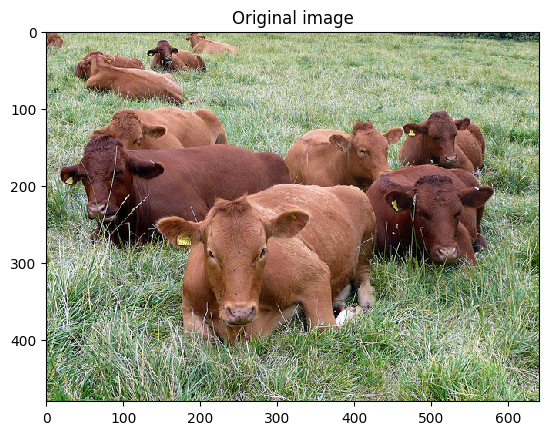

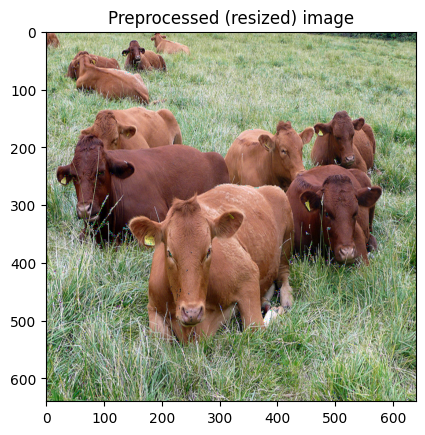

In [6]:
def preproc(image, output_height=MODEL_HEIGHT, output_width=MODEL_WIDTH):
    resized_image = tf.image.resize(image, (output_height, output_width), method='bicubic')
    return tf.squeeze(resized_image)

images_path = '../Data/coco_val2017'
images_list = [img_name for img_name in os.listdir(images_path) if
               os.path.splitext(os.path.join(images_path, img_name))[1] == '.jpg']
random.shuffle(images_list)

calib_dataset = np.zeros((min(max_image_for_optimization, len(images_list)), MODEL_HEIGHT, MODEL_WIDTH, 3), dtype=np.float32)
for idx, img_name in enumerate(images_list):
    if idx >= min(max_image_for_optimization, len(images_list)):
        idx= idx - 1
        break    
    img = np.array(Image.open(os.path.join(images_path, img_name)))
    
    # In case of grayscale image, convert to color
    if (img.ndim == 2):
        img_color= np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        img_color[:,:, 0]= img
        img_color[:,:, 1]= img
        img_color[:,:, 2]= img
        img= img_color
    
    img_preproc = preproc(img)
    calib_dataset[idx,:,:,:] = img_preproc.numpy().astype(np.uint8)

np.save('calib_set.npy', calib_dataset)

%matplotlib inline

plt.figure()
plt.imshow(img, interpolation='nearest')
plt.title('Original image')
plt.figure()
plt.imshow(np.array(calib_dataset[idx,:,:,:], np.uint8))
plt.title('Preprocessed (resized) image')


Run the quantization process:

Note that this will run naive quantization, for advanced topics in quantization please refer to the advanced section below.

In [7]:
csv_path = 'translated_params.csv'
quantized_model_har_path = '{}_quantized_model.har'.format(model_name)

runner = ClientRunner(hw_arch='hailo8', har_path=hailo_model_har_name)

alls_lines = [
        'normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n',
    ]
    
open('simple_script.alls','w').writelines(alls_lines)

runner.load_model_script('simple_script.alls')
runner.optimize(calib_dataset) # calib_dataset needs to contain at least 1024 images to kick-off optimization level 1

[info] Loading model script to yolov6_v040 from simple_script.alls
[info] Starting Model Optimization
[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's less data than the recommended amount (1024), and there's no available GPU
[info] Using dataset with 64 entries for calibration
[info] Starting Stats Collector


Calibration: 100%|████████████████████████████████████████████████████████████████████████| 64/64 [00:45<00:00,  1.41entries/s]


[info] Stats Collector is done (completion time is 00:00:46.07)
[info] Bias Correction skipped
[info] Adaround skipped
[info] Fine Tune skipped
[info] Layer Noise Analysis skipped
[info] Model Optimization is done


Evaluate the results by comparing the results of the native and the numeric emulation modes:

In [8]:
runner.save_har(quantized_model_har_path)